# Profile Bayesian Modeling

This notebook runs the main Bayesian model for user profile distributions.

## Setup

In [1]:
library(psych)
library(rstan)
library(loo)
library(iterators)
library(foreach)
library(assertthat)
library(tidyverse)

Loading required package: ggplot2

Attaching package: ‘ggplot2’

The following objects are masked from ‘package:psych’:

    %+%, alpha

Loading required package: StanHeaders
rstan (Version 2.17.3, GitRev: 2e1f913d3ca3)
For execution on a local, multicore CPU with excess RAM we recommend calling
options(mc.cores = parallel::detectCores()).
To avoid recompilation of unchanged Stan programs, we recommend calling
rstan_options(auto_write = TRUE)

Attaching package: ‘rstan’

The following object is masked from ‘package:psych’:

    lookup

This is loo version 1.1.0
── Attaching packages ─────────────────────────────────────── tidyverse 1.2.1 ──
✔ tibble  1.4.1     ✔ purrr   0.2.4
✔ tidyr   0.7.2     ✔ dplyr   0.7.4
✔ readr   1.1.1     ✔ stringr 1.2.0
✔ tibble  1.4.1     ✔ forcats 0.2.0
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ ggplot2::%+%()      masks psych::%+%()
✖ purrr::accumulate() masks foreach::accumulate()
✖ ggplot2::alpha()    masks psych::

In [2]:
if (file.exists("build/ProfileModels.rda")) {
    message("importing data")
    load("build/ProfileModels.rda")
}

importing data


In [3]:
options(mc.cores=parallel::detectCores())
rstan_options(auto_write=TRUE)

In [4]:
options(repr.matrix.max.rows=20)
options(repr.plot.height=5,
        repr.plot.width=10)

In [5]:
source("utils.R")

In [6]:
db = DBI::dbConnect(RPostgreSQL::PostgreSQL(), "openlib")

## Load User Profiles and Background Data

We have author-gender information for a bunch of books:

In [7]:
author_gender = tbl(db, 'cluster_first_author_gender') %>% select(bookID=cluster, gender) %>%
    collect()
head(author_gender)

bookID,gender
101891138,female
113484902,male
105203065,unknown
100940351,male
206535758,no-loc-author
110621222,no-viaf-author


Load the implicit ratings for the implicit feedback user sample.

In [8]:
bx_implicit_ratings = read_csv("build/sample-ratings-implicit.csv", guess_max = 10000)

Parsed with column specification:
cols(
  userID = col_integer(),
  bookID = col_integer(),
  rating = col_double()
)


Load the explicit ratings for the explicit feedback user sample;

In [9]:
bx_explicit_ratings = read_csv("build/sample-ratings-explicit.csv", guess_max=10000)

Parsed with column specification:
cols(
  userID = col_integer(),
  bookID = col_integer(),
  rating = col_double()
)


Load the explicit ratings for the explicit feedback user sample of Amazon data

In [10]:
az_explicit_ratings = read_csv("build/sample-ratings-amazon.csv", guess_max=10000)

Parsed with column specification:
cols(
  userID = col_integer(),
  bookID = col_integer(),
  rating = col_double()
)


And merge them together

In [11]:
user_ratings =
    bind_rows(BXA = bx_implicit_ratings,
              BXE = bx_explicit_ratings,
              AZ = az_explicit_ratings,
              .id="Set")

## Summarize User Profiles

We will integrate user ratings with book information and summarize, so we can start to see what things look like.

In [12]:
user_books = user_ratings %>%
    left_join(author_gender) %>%
    mutate(gender = recode_factor(gender,
                                  female="female", male="male", ambiguous="ambiguous", unknown="unknown",
                                  .default='unlinked', .missing='unlinked', .ordered=TRUE)) %>%
    transmute(Set = as.factor(Set),
              userID = userID, bookID = bookID, rating=rating,
              gender=gender)
user_books %>%
    select(Set, gender) %>%
    summary()

Joining, by = "bookID"


  Set              gender     
 AZ :31218   female   :36476  
 BXA:52902   male     :43658  
 BXE:33852   ambiguous: 4010  
             unknown  : 9034  
             unlinked :24794  

In [13]:
profile_info = user_books %>%
    group_by(Set, userID) %>%
    summarize(count=n(),
              linked=sum(gender != 'unlinked'),
              ambiguous = sum(gender == 'ambiguous'),
              NMale = sum(gender == 'male'),
              NFemale = sum(gender == 'female')) %>%
    ungroup() %>%
    mutate(known = NMale + NFemale,
           PropFemale = NFemale/known,
           PropKnown = known/count)
profile_info

Set,userID,count,linked,ambiguous,NMale,NFemale,known,PropFemale,PropKnown
AZ,1306,7,6,0,5,0,5,0.00000000,0.7142857
AZ,8296,9,7,0,4,3,7,0.42857143,0.7777778
AZ,9047,27,17,0,12,0,12,0.00000000,0.4444444
AZ,21468,9,8,0,1,5,6,0.83333333,0.6666667
AZ,29992,25,19,0,13,1,14,0.07142857,0.5600000
AZ,47631,14,6,0,2,3,5,0.60000000,0.3571429
AZ,62885,25,19,0,15,1,16,0.06250000,0.6400000
AZ,66610,17,11,0,11,0,11,0.00000000,0.6470588
AZ,73428,15,14,0,6,6,12,0.50000000,0.8000000
AZ,76016,10,5,0,3,2,5,0.40000000,0.5000000


### Link Coverage

What is the coverage over _distinct rated books_?

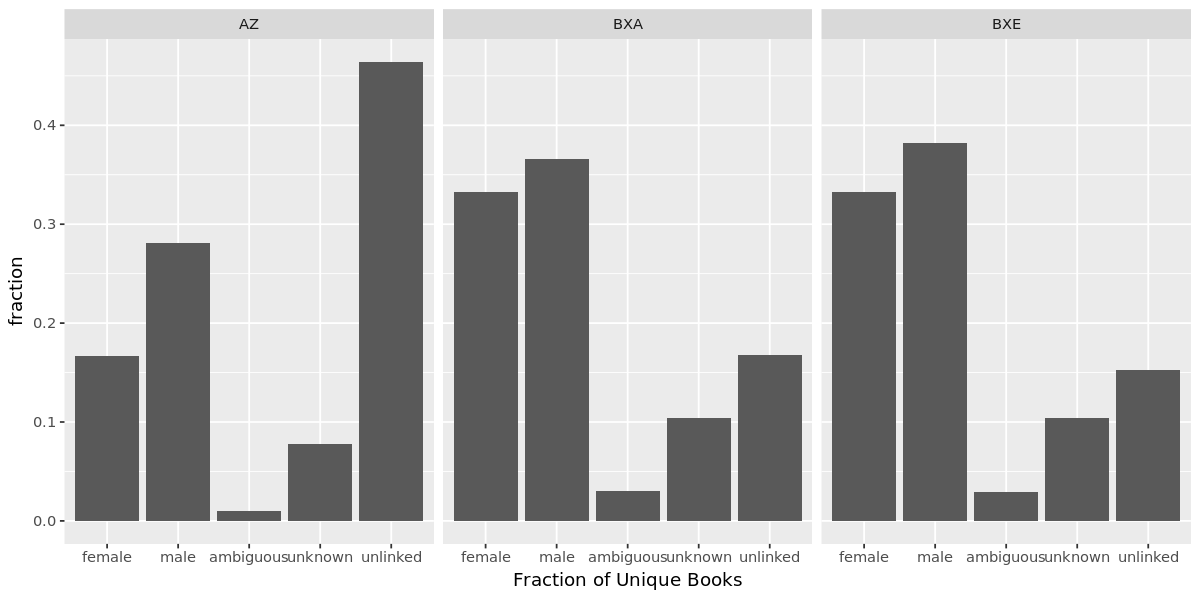

In [15]:
book_coverage = user_books %>%
    select(Set, bookID, gender) %>%
    distinct() %>%
    group_by(Set, gender) %>%
    summarize(count=n()) %>%
    group_by(Set) %>%
    mutate(fraction=count / sum(count))
drawplot(file='build/figures/resolution-unique-books', width=5, height=2.5, {
    ggplot(book_coverage) +
        aes(x=gender, y=fraction) +
        geom_bar(stat='identity') +
        facet_grid(~ Set) +
        xlab('Fraction of Unique Books')
})

In [16]:
book_coverage %>%
    select(Set, gender, fraction) %>%
    spread(Set, fraction)

gender,AZ,BXA,BXE
female,0.166902816,0.33296388,0.33219604
male,0.281416894,0.36541905,0.38176855
ambiguous,0.009881926,0.03012476,0.02934211
unknown,0.077820163,0.10390201,0.10380123
unlinked,0.463978202,0.16759030,0.15289206


Analyze in what we need to know:

In [17]:
book_coverage %>%
    select(Set, gender, fraction) %>%
    spread(gender, fraction) %>%
    transmute(known=female + male, unknown=unknown + unlinked, ambiguous=ambiguous)

Adding missing grouping variables: `Set`


Set,known,unknown,ambiguous
AZ,0.4483197,0.5417984,0.009881926
BXA,0.6983829,0.2714923,0.030124762
BXE,0.7139646,0.2566933,0.029342111


We have 65-70% coverage over books in BX, and 45% in Amazon.

What is the coverage over *ratings*?

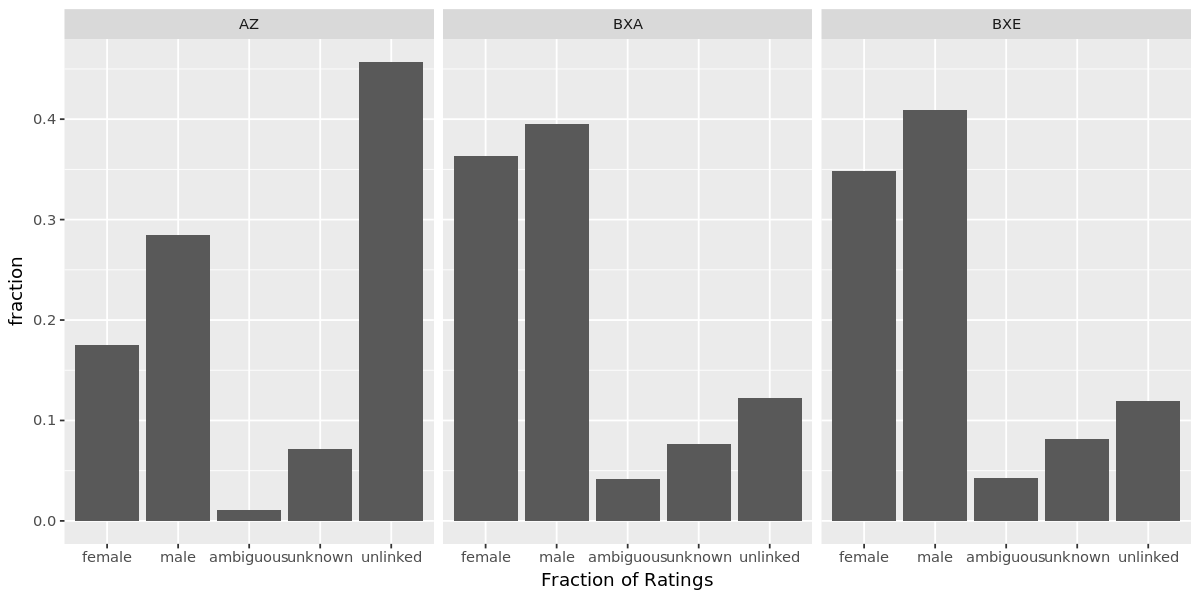

In [18]:
rating_coverage = user_books %>%
    select(Set, bookID, gender) %>%
    group_by(Set, gender) %>%
    summarize(count=n()) %>%
    group_by(Set) %>%
    mutate(fraction=count / sum(count))
drawplot(file='build/figures/resolution-ratings', width=5, height=2.5, {
    ggplot(rating_coverage) +
        aes(x=gender, y=fraction) +
        geom_bar(stat='identity') +
        facet_grid(~ Set) +
        xlab('Fraction of Ratings')
})

In [19]:
rating_coverage %>%
    select(Set, gender, fraction) %>%
    spread(Set, fraction)

gender,AZ,BXA,BXE
female,0.17553975,0.36327549,0.34792627
male,0.28489974,0.39524026,0.40928158
ambiguous,0.01111538,0.04198329,0.04259719
unknown,0.07152925,0.07663226,0.08114735
unlinked,0.45691588,0.12286870,0.11904762


In [20]:
rating_coverage %>%
    select(Set, gender, fraction) %>%
    spread(gender, fraction) %>%
    transmute(known=female + male, unknown=unknown+unlinked, ambiguous=ambiguous)

Adding missing grouping variables: `Set`


Set,known,unknown,ambiguous
AZ,0.4604395,0.5284451,0.01111538
BXA,0.7585157,0.1995010,0.04198329
BXE,0.7572078,0.2001950,0.04259719


We have 73% coverage over ratings (47% for Amazon)

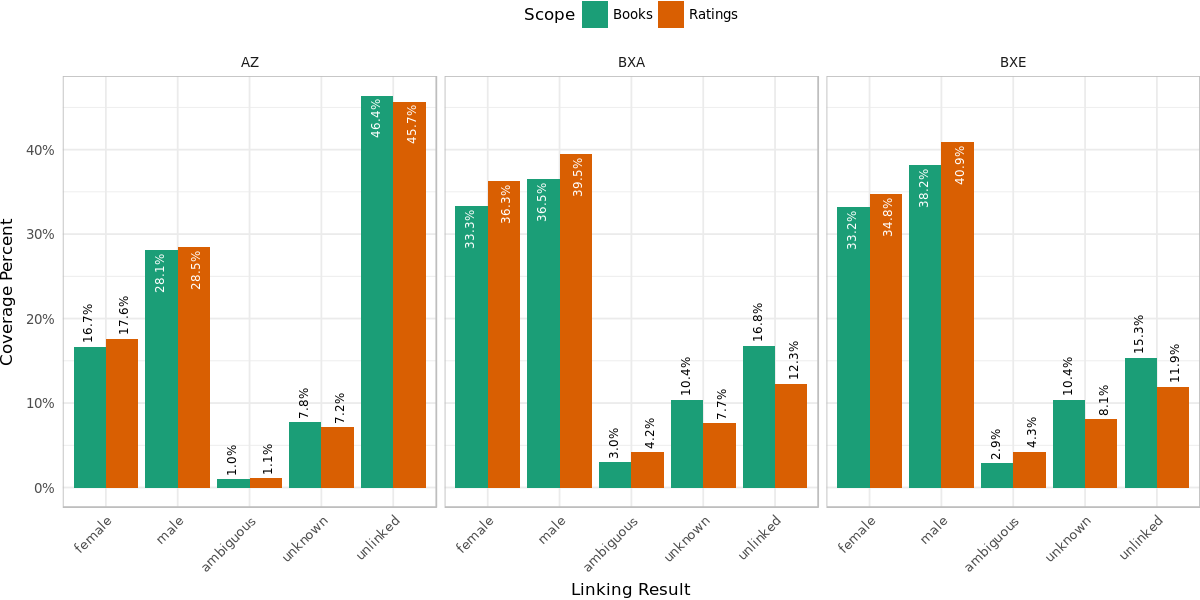

In [21]:
gender_coverage = bind_rows(Books=book_coverage, Ratings=rating_coverage, .id="Scope")
drawplot(file='build/figures/gender-coverage', width=5, height=2.8, {
ggplot(gender_coverage) +
    aes(x=gender, y=fraction, fill=Scope, label=sprintf("%.1f%%", fraction * 100)) +
    geom_bar(stat='identity', position='dodge') +
    geom_text(mapping=aes(hjust=if_else(fraction > 0.2, 1.1, -0.1),
                          colour=if_else(fraction > 0.2, 'white', 'black')),
              position=position_dodge(width=1), 
              size=2.5, angle=90) +
    facet_grid(~ Set) +
    scale_y_continuous(labels=scales::percent) +
    scale_fill_brewer(palette = "Dark2") +
    scale_colour_identity() +
    ylab("Coverage Percent") +
    xlab("Linking Result") +
    theme_paper() +
    theme(legend.position='top', axis.text.x = element_text(angle=45, hjust=1),
          legend.margin=margin())
})

### How are profiles sizes distributed?

First, we want to see the distribution of _profile sizes_:

In [22]:
profile_info %>% filter(Set == "AZ") %>% pull(known) %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00    5.00    7.00   14.37   11.00  563.00 

In [23]:
profile_info %>% filter(Set == "BXE") %>% pull(known) %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00    6.00   10.00   25.63   19.00 4258.00 

In [24]:
profile_info %>% filter(Set == "BXA") %>% pull(known) %>% summary()

   Min. 1st Qu.  Median    Mean 3rd Qu.    Max. 
   5.00    7.00   11.00   40.13   25.00 3334.00 

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


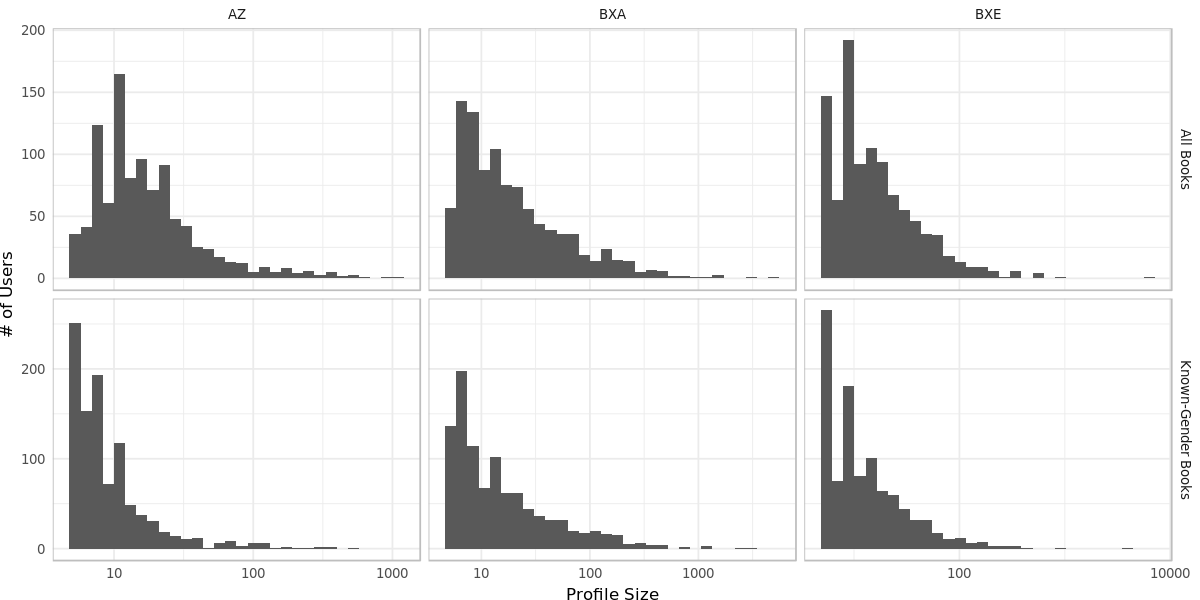

In [51]:
profile_stats = profile_info %>%
    select(Set, userID, count, known) %>%
    gather("Scope", "Value", count, known) %>%
    mutate(Scope = recode_factor(Scope,
                                 count="All Books",
                                 known="Known-Gender Books",
                                 .ordered=TRUE))
drawplot(file='build/figures/profile-size-dist', width=5, height=2.5, {
    ggplot(profile_stats) +
        aes(x=Value) +
        geom_histogram() +
        facet_grid(Scope ~ Set, scales="free") +
        scale_x_log10() +
        xlab("Profile Size") +
        ylab("# of Users") +
        theme_paper()
})

Lots of concentration low, and some outliers. We will filter out large profiles.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


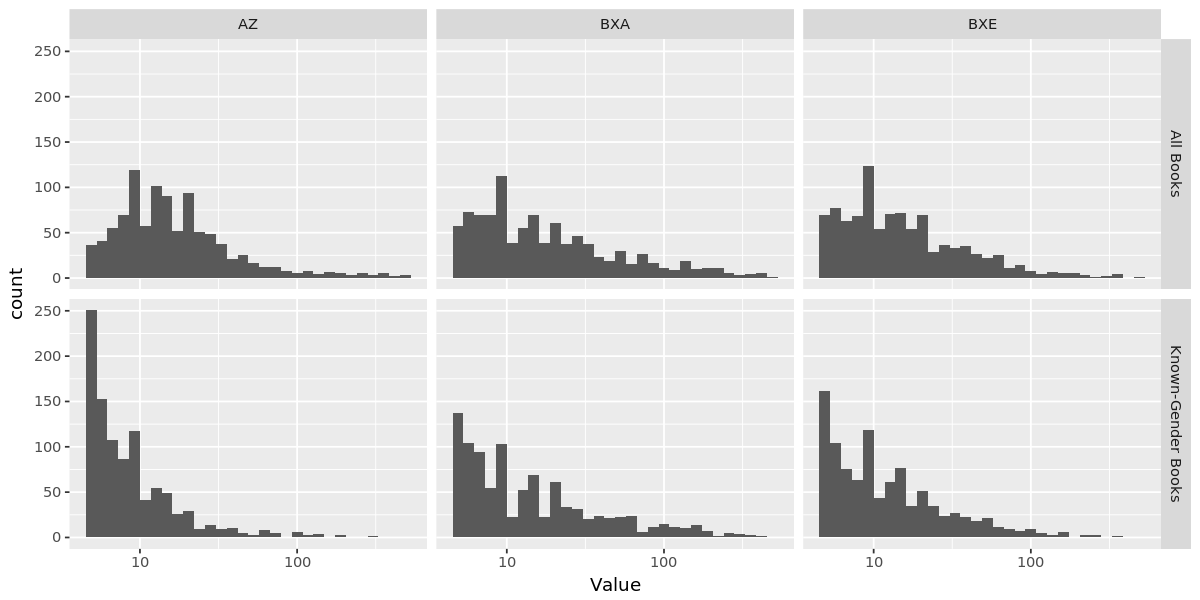

In [26]:
ggplot(filter(profile_stats, Value <= 500)) +
    aes(x=Value) +
    geom_histogram() +
    facet_grid(Scope ~ Set) +
    scale_x_log10()

In [27]:
profile_info %>%
    transmute(userID, Set, keep = known <= 250) %>%
    spread(Set, keep) %>%
    summary()

     userID            AZ             BXA             BXE         
 Min.   :    272   Mode :logical   Mode :logical   Mode :logical  
 1st Qu.: 102672   FALSE:5         FALSE:21        FALSE:9        
 Median : 206918   TRUE :995       TRUE :979       TRUE :991      
 Mean   :1430651   NA's :1956      NA's :1956      NA's :1956     
 3rd Qu.:1978048                                                  
 Max.   :8024269                                                  

Let's look at fraction known:

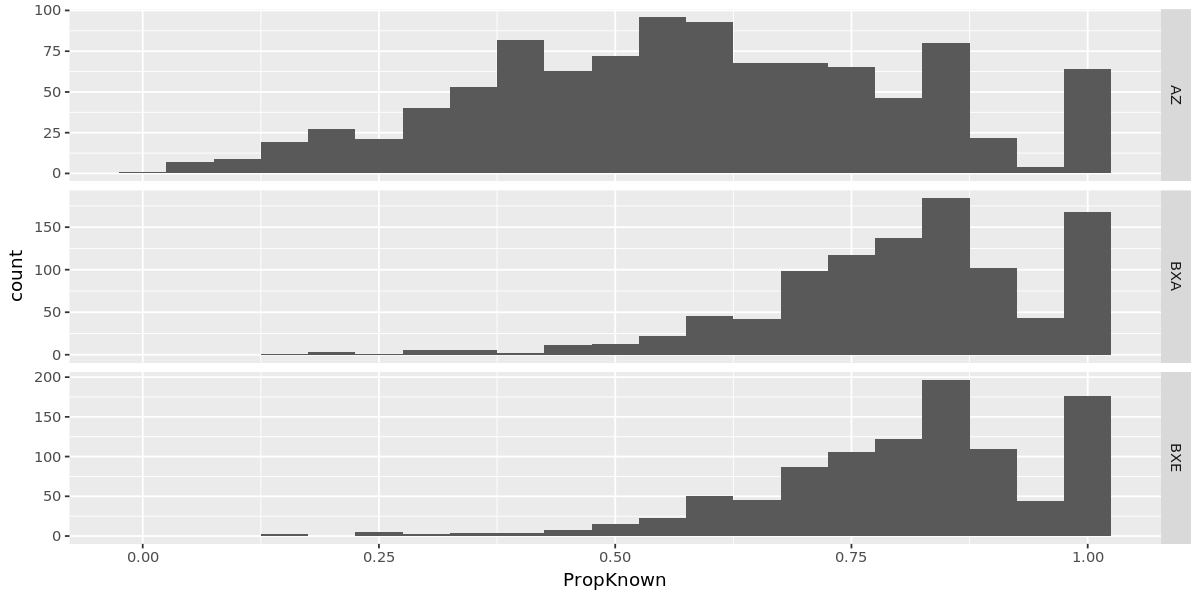

In [28]:
ggplot(profile_info) +
    aes(x=PropKnown) +
    geom_histogram(binwidth=0.05) +
    facet_grid(Set ~ ., scales="free_y")

## How are profile gender biases distributed?

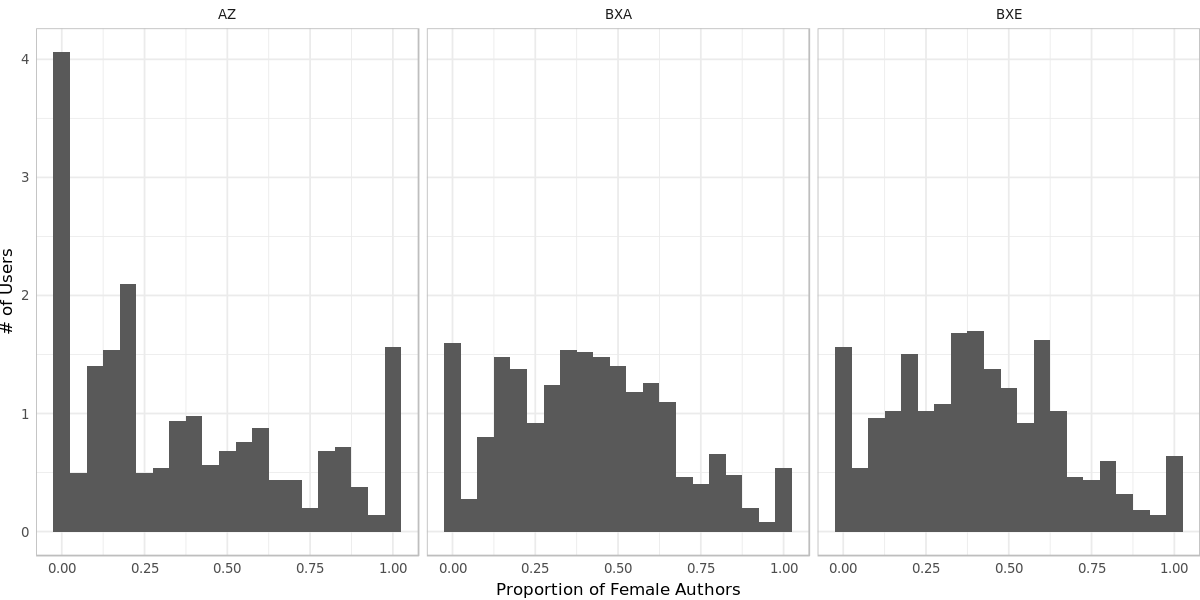

In [17]:
drawplot(file='build/figures/profile-prop-dist', width=5, height=1.5, {
    ggplot(profile_info) +
        aes(x=PropFemale, y=..density..) +
        geom_histogram(binwidth=0.05) +
        facet_grid(~ Set) +
        xlab("Proportion of Female Authors") +
        ylab("# of Users") +
        theme_paper()
})

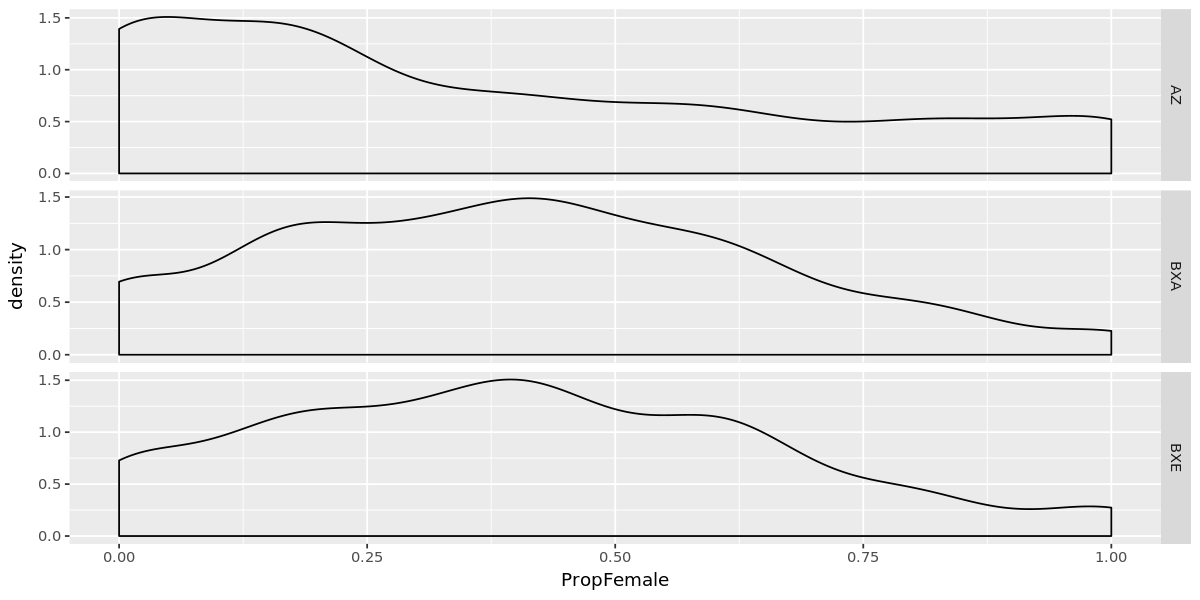

In [30]:
ggplot(profile_info) +
    aes(x=PropFemale) +
    geom_density() +
    facet_grid(Set ~ ., scales="free_y")

## Bayesian Modeling

We will start by compiling our model:

In [ ]:
profile_model = stan_model(file="models/profile.stan")
profile_model

In [32]:
wanted_vars = c("mu", "sigma", "nMean", "nDisp", "thetaP", "nP", "yP")

### BookCrossing Explicit Fit

Fit the BookCrossing explicit data:

In [33]:
bxe_data = profile_info %>% filter(Set == 'BXE')
bxe_fit = sampling(profile_model,
                   data=list(J=nrow(bxe_data),
                             n=array(bxe_data$known),
                             y=array(bxe_data$NFemale)),
                   chains=4, iter=5000)

In [34]:
print(bxe_fit, pars=wanted_vars)

Inference for Stan model: profile.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

        mean se_mean    sd  2.5%   25%   50%   75%  97.5% n_eff Rhat
mu     -0.45    0.00  0.04 -0.53 -0.48 -0.45 -0.42  -0.37 10000    1
sigma   1.11    0.00  0.04  1.04  1.08  1.11  1.14   1.19  4376    1
nMean  20.75    0.01  1.11 18.71 19.97 20.72 21.47  23.02 10000    1
nDisp   0.36    0.00  0.02  0.34  0.35  0.36  0.38   0.40 10000    1
thetaP  0.41    0.00  0.22  0.06  0.23  0.39  0.57   0.85  9966    1
nP     26.19    0.36 35.57  5.00  6.00 12.00 31.00 133.00  9844    1
yP     10.77    0.18 17.95  0.00  2.00  5.00 11.00  59.00 10000    1

Samples were drawn using NUTS(diag_e) at Sun May  6 16:02:17 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### BookCrossing Implicit

In [35]:
bxi_data = profile_info %>% filter(Set == 'BXA')
bxi_fit = sampling(profile_model,
                   data=list(J=nrow(bxi_data),
                             n=bxi_data$known,
                             y=bxi_data$NFemale),
                   chains=4, iter=5000)

In [36]:
print(bxi_fit, pars=wanted_vars)

Inference for Stan model: profile.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

        mean se_mean    sd  2.5%   25%   50%   75%  97.5% n_eff Rhat
mu     -0.42    0.00  0.04 -0.50 -0.44 -0.42 -0.39  -0.34 10000    1
sigma   1.03    0.00  0.04  0.96  1.01  1.03  1.06   1.11  4141    1
nMean  35.33    0.02  1.98 31.66 33.97 35.26 36.61  39.44 10000    1
nDisp   0.32    0.00  0.01  0.30  0.31  0.32  0.33   0.35 10000    1
thetaP  0.42    0.00  0.21  0.08  0.25  0.40  0.57   0.83 10000    1
nP     40.59    0.65 64.53  5.00  6.00 14.00 46.00 232.00 10000    1
yP     17.06    0.32 31.74  0.00  2.00  5.00 17.00 103.02 10000    1

Samples were drawn using NUTS(diag_e) at Sun May  6 16:05:13 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Amazon Data

In [37]:
start = Sys.time()
az_data = profile_info %>% filter(Set == 'AZ')
az_fit = sampling(profile_model,
                  data=list(J=nrow(az_data),
                            n=az_data$known,
                            y=az_data$NFemale),
                  iter=5000, chains=4)
Sys.time() - start

Time difference of 2.159939 mins

In [38]:
print(az_fit, pars=wanted_vars)

Inference for Stan model: profile.
4 chains, each with iter=5000; warmup=2500; thin=1; 
post-warmup draws per chain=2500, total post-warmup draws=10000.

        mean se_mean    sd  2.5%   25%   50%   75% 97.5% n_eff Rhat
mu     -0.83    0.00  0.07 -0.97 -0.88 -0.83 -0.79 -0.70 10000    1
sigma   1.90    0.00  0.07  1.77  1.86  1.90  1.95  2.04  3460    1
nMean   9.43    0.01  0.52  8.47  9.07  9.41  9.76 10.47 10000    1
nDisp   0.35    0.00  0.02  0.31  0.33  0.34  0.36  0.38 10000    1
thetaP  0.37    0.00  0.29  0.01  0.11  0.30  0.61  0.95 10000    1
nP     14.30    0.16 16.04  5.00  5.00  8.00 16.00 61.00 10000    1
yP      5.35    0.09  8.90  0.00  1.00  3.00  6.00 29.00 10000    1

Samples were drawn using NUTS(diag_e) at Sun May  6 16:07:36 2018.
For each parameter, n_eff is a crude measure of effective sample size,
and Rhat is the potential scale reduction factor on split chains (at 
convergence, Rhat=1).


### Render Densities

And extract the simulated values so we can do further analysis.

In [39]:
fits = list(BXE=bxe_fit, BXA=bxi_fit, AZ=az_fit)

In [40]:
sims = map_dfr(fits, function(fit) {
    sim = rstan::extract(fit, permuted=TRUE)
    data_frame(Sim=1:nrow(sim$thetaP),
               Mu=sim$mu, Sigma=sim$sigma,
               NMean=sim$nMean, NDisp=sim$nDisp,
               LogOdds=sim$nThetaP, Theta=sim$thetaP, N=sim$nP, Y=sim$yP) %>%
        mutate(Prop=ifelse(N > 0, Y/N, NA))
}, .id="Set")
sims

Set,Sim,Mu,Sigma,NMean,NDisp,LogOdds,Theta,N,Y,Prop
BXE,1,-0.5259305,1.132337,19.34941,0.3771538,-0.28820572,0.42844319,81,36,0.4444444
BXE,2,-0.4707385,1.130410,19.85528,0.3616323,1.40674589,0.80325218,7,5,0.7142857
BXE,3,-0.4796466,1.091104,19.52989,0.3366009,-2.41318205,0.08217301,16,1,0.0625000
BXE,4,-0.4405054,1.117057,21.76720,0.3574434,0.95933781,0.72298920,23,15,0.6521739
BXE,5,-0.4080204,1.108114,21.33437,0.3412775,-1.46256565,0.18807523,6,2,0.3333333
BXE,6,-0.4590097,1.103673,20.52323,0.3562075,-0.78591032,0.31304748,17,6,0.3529412
BXE,7,-0.4240732,1.199028,21.28944,0.3470525,0.10355958,0.52586678,5,3,0.6000000
BXE,8,-0.4463302,1.124890,20.18735,0.3647728,-0.08766635,0.47809744,27,9,0.3333333
BXE,9,-0.4146734,1.148430,21.63345,0.3596237,0.74155310,0.67733538,5,4,0.8000000
BXE,10,-0.4176961,1.095530,20.32801,0.4023167,0.23871827,0.55939776,22,13,0.5909091


In [41]:
sims %>%
    group_by(Set) %>%
    summarize(N=n(),
              LMean=mean(Mu), 
              LMean.Lo=quantile(Mu, 0.025), 
              LMean.Hi=quantile(Mu, 0.975),
              Mean=logistic(LMean),
              SD=mean(Sigma),
              SD.Lo=quantile(Sigma, 0.025),
              SD.Hi=quantile(Sigma, 0.975),
              Prop=mean(Theta),
              Prop.Lo=quantile(Theta, 0.025), 
              Prop.Hi=quantile(Theta, 0.975),
              Prop.Var=var(Theta),
              Prop.SD=sd(Theta))

Set,N,LMean,LMean.Lo,LMean.Hi,Mean,SD,SD.Lo,SD.Hi,Prop,Prop.Lo,Prop.Hi,Prop.Var,Prop.SD
AZ,10000,-0.8338862,-0.9692797,-0.6994430,0.3028240,1.903646,1.7741239,2.044710,0.3728698,0.01010314,0.9479444,0.08657198,0.2942312
BXA,10000,-0.4175056,-0.4950311,-0.3387974,0.3971138,1.033512,0.9635679,1.107328,0.4175196,0.08300664,0.8261766,0.04301736,0.2074063
BXE,10000,-0.4512953,-0.5325625,-0.3684173,0.3890529,1.109602,1.0351459,1.187966,0.4113264,0.06395042,0.8532331,0.04775964,0.2185398


In [42]:
profile_info %>% transmute(PropFemale, LogOdds=logit(PropFemale)) %>% summary()

   PropFemale        LogOdds       
 Min.   :0.0000   Min.   :   -Inf  
 1st Qu.:0.1667   1st Qu.:-1.6094  
 Median :0.3750   Median :-0.5108  
 Mean   :0.3948   Mean   :    NaN  
 3rd Qu.:0.6000   3rd Qu.: 0.4055  
 Max.   :1.0000   Max.   :    Inf  

In [53]:
profile_info %>% 
    group_by(Set) %>%
    summarize(Prop.Mean=mean(PropFemale), Prop.SD=sd(PropFemale),
              LogOdds.Mean=mean(logit(PropFemale)),
              LogOdds.Med=median(logit(PropFemale)),
              LogOdds.SD=sd(logit(PropFemale)))

Set,Prop.Mean,Prop.SD,LogOdds.Mean,LogOdds.Med,LogOdds.SD
AZ,0.3664051,0.3249353,NaN,-0.9980300,NaN
BXA,0.4102683,0.2522821,NaN,-0.4054651,NaN
BXE,0.4076881,0.2551468,NaN,-0.4054651,NaN


In [44]:
results = sims %>% select(Set, Estimated=Theta, Predicted=Prop) %>%
    gather("Method", "Value", Estimated, Predicted) %>%
    bind_rows(profile_info %>% select(Set, Value=PropFemale) %>% mutate(Method="Observed") %>% filter(!is.na(Value)) %>%
                 sample_n(10000, replace=TRUE))

Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

In [45]:
means = results %>%
    group_by(Set, Method) %>%
    summarize(Mean=mean(Value),
              Var=var(Value),
              SD=sd(Value),
              CI.Lo=quantile(Value, 0.025),
              CI.Hi=quantile(Value, 0.975))
means

Set,Method,Mean,Var,SD,CI.Lo,CI.Hi
AZ,Estimated,0.3728698,0.08657198,0.2942312,0.01010314,0.9479444
AZ,Observed,0.3713753,0.10585974,0.3253609,0.00000000,1.0000000
AZ,Predicted,0.3769118,0.10447574,0.3232271,0.00000000,1.0000000
BXA,Estimated,0.4175196,0.04301736,0.2074063,0.08300664,0.8261766
BXA,Observed,0.4079534,0.06355578,0.2521027,0.00000000,1.0000000
BXA,Predicted,0.4171184,0.06260633,0.2502126,0.00000000,0.9166667
BXE,Estimated,0.4113264,0.04775964,0.2185398,0.06395042,0.8532331
BXE,Observed,0.4133462,0.06495005,0.2548530,0.00000000,1.0000000
BXE,Predicted,0.4109020,0.06644769,0.2577745,0.00000000,1.0000000


In [18]:
result_dens = results %>%
    group_by(Set, Method) %>%
    summarize(Dens=list(density_frame(Value, from=0, to=1, adjust=0.5))) %>%
    unnest(Dens)

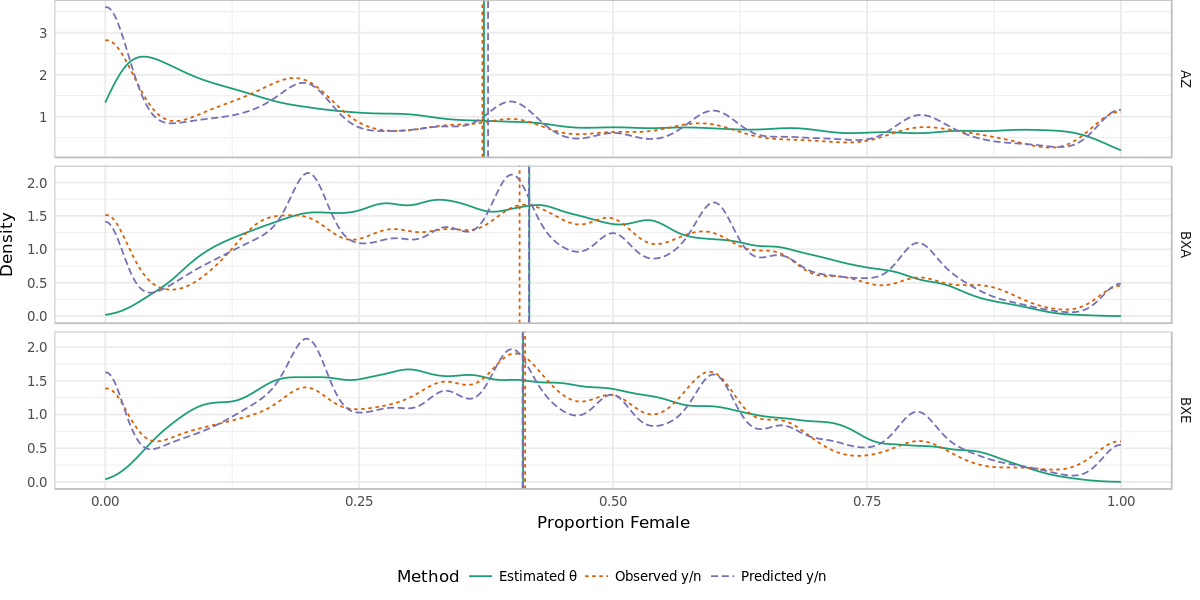

In [19]:
drawplot(file='build/figures/profile-posterior', width=5, height=2.8, {
    ggplot(result_dens) +
        aes(x=value, y=density, color=Method, linetype=Method) +
        geom_line() +
        geom_vline(data=means, mapping=aes(xintercept=Mean, color=Method, linetype=Method),
                   show.legend=FALSE) +
        facet_grid(Set ~ ., scales = 'free') +
        scale_color_brewer(palette="Dark2",
                           labels=c(Estimated="Estimated θ",
                                    Observed="Observed y/n",
                                    Predicted="Predicted y/n")) +
        scale_linetype_discrete(labels=c(Estimated="Estimated θ",
                                    Observed="Observed y/n",
                                    Predicted="Predicted y/n")) +
        xlab("Proportion Female") + ylab("Density") +
        theme_paper() + theme(legend.position="bottom")
})

Now, let's draw a version of this that includes the histograms.

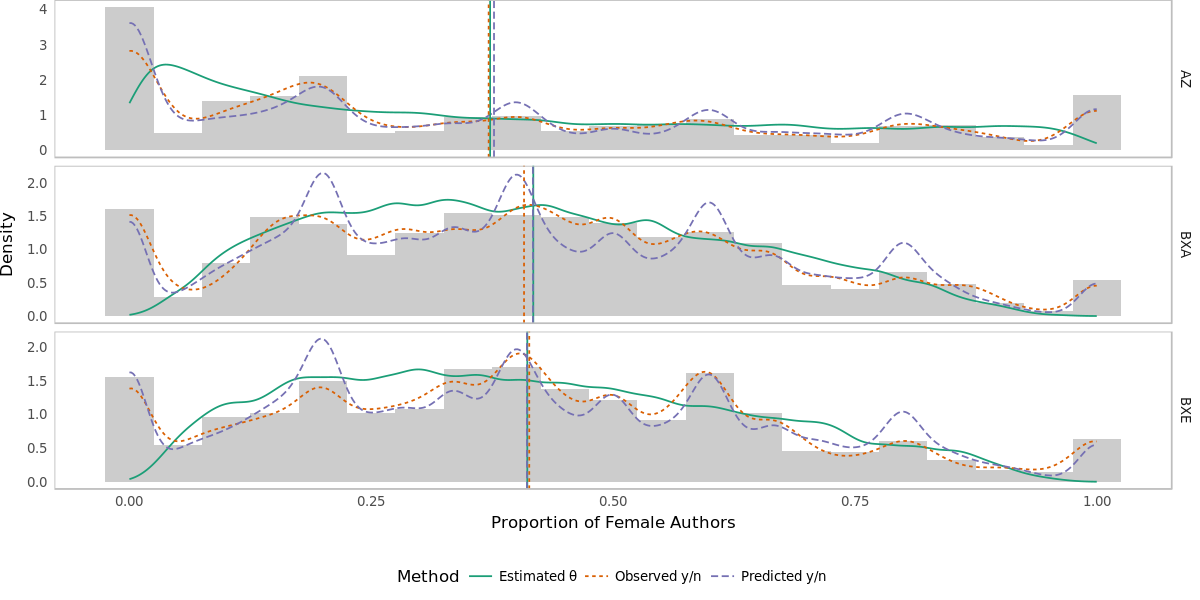

In [34]:
drawplot(file='build/figures/profile-integrated', width=5, height=2.8, {
    ggplot(profile_info) +
        aes(x=PropFemale, y=..density..) +
        geom_histogram(binwidth=0.05, fill="gray80") +
        geom_line(data=result_dens, mapping=aes(x=value, y=density, color=Method, linetype=Method)) +
        geom_vline(data=means, mapping=aes(xintercept=Mean, color=Method, linetype=Method),
                   show.legend=FALSE) +
        facet_grid(Set ~ ., scales = 'free') +
        scale_color_brewer(palette="Dark2",
                           labels=c(Estimated="Estimated θ",
                                    Observed="Observed y/n",
                                    Predicted="Predicted y/n")) +
        scale_linetype_discrete(labels=c(Estimated="Estimated θ",
                                    Observed="Observed y/n",
                                    Predicted="Predicted y/n")) +
        xlab("Proportion of Female Authors") +
        ylab("Density") +
        theme_paper() + theme(legend.position="bottom", panel.grid=element_blank())
})

## More Diagnostics

Let's plot histograms of observed & predicted proportions:

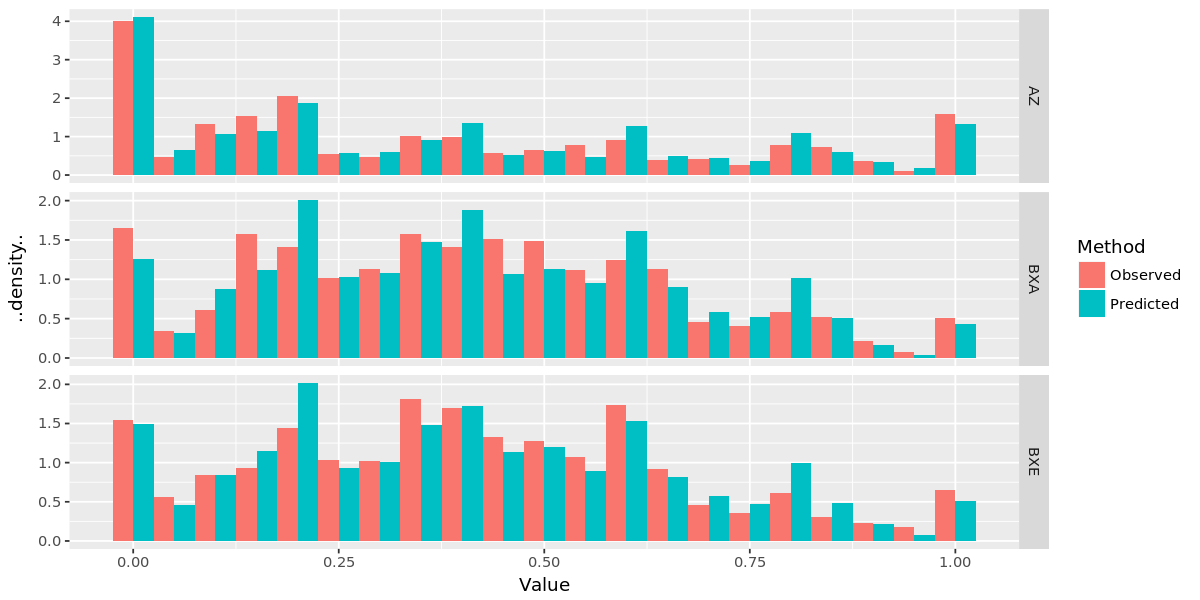

In [48]:
ggplot(results %>% filter(Method != "Estimated")) +
    aes(x=Value, fill=Method, y=..density..) +
    geom_histogram(binwidth=0.05, position="dodge") +
    facet_grid(Set ~ ., scales="free_y")

Let's do this with profile sizes:

Warning message in bind_rows_(x, .id):
“binding character and factor vector, coercing into character vector”

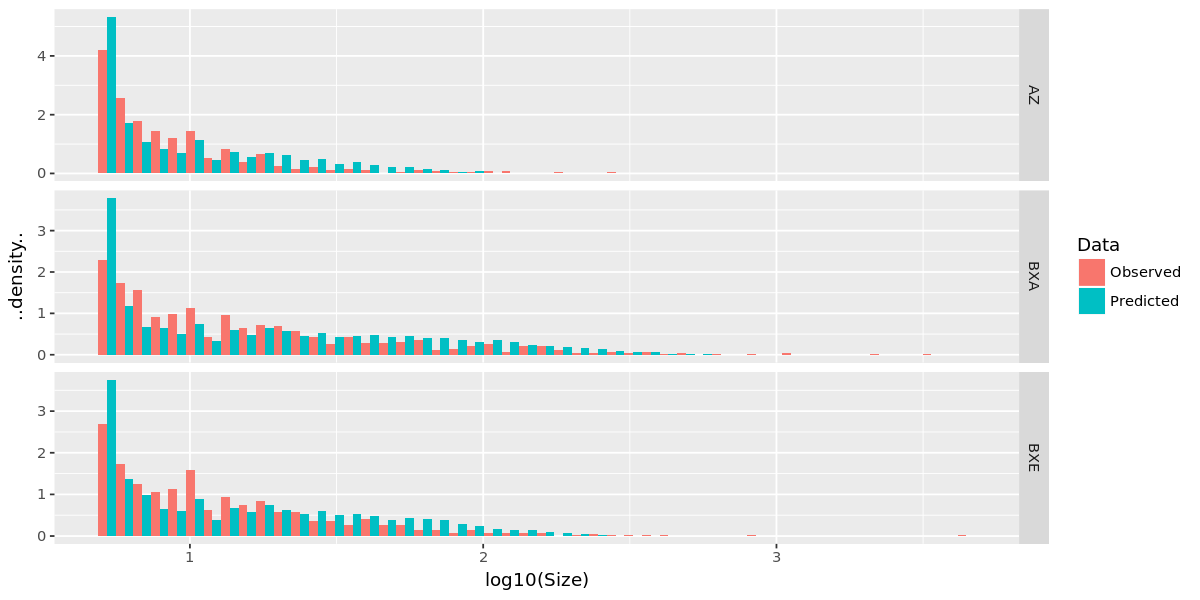

In [49]:
sizes = 
    bind_rows(Predicted = sims %>% select(Set, Size=N),
              Observed = profile_info %>% select(Set, Size=known),
              .id="Data")
ggplot(sizes) +
    aes(x=log10(Size), fill=Data, y=..density..) +
    geom_histogram(bins=50, position="dodge") +
    facet_grid(Set ~ ., scales="free_y")

## Save

In [50]:
save.image("build/ProfileModels.rda")